# Universal Cell Embeddings
If you want to learn more about the method please read the [paper](https://www.biorxiv.org/content/10.1101/2023.11.28.568918v1) and the [SATURN method](https://www.nature.com/articles/s41592-024-02191-z).

In [1]:
from accelerate import Accelerator
import anndata as ad
import numpy as np

Before using the UCE Model please define your model configurations below

In [2]:
model_config  = {
    "model_loc": "./model_files/4layer_model.torch",#"./model_files/33l_8ep_1024t_1280.torch",
    "batch_size": 5, #25,
    "pad_length": 1536,
    "pad_token_idx": 0,
    "chrom_token_left_idx": 1,
    "chrom_token_right_idx": 2,
    "cls_token_idx": 3,
    "CHROM_TOKEN_OFFSET": 143574,
    "sample_size": 1024,
    "CXG": True,
    "n_layers": 4,#33,
    "output_dim": 1280,
    "d_hid": 5120,
    "token_dim": 5120,
    "multi_gpu": False
}

files_config = {
    "spec_chrom_csv_path": "./model_files/species_chrom.csv",
    "token_file": "./model_files/all_tokens.torch",
    "protein_embeddings_dir": "./model_files/protein_embeddings/",
    "offset_pkl_path": "./model_files/species_offsets.pkl"
}

data_config = {
    "adata_path": "../data/full_cells_macaca_obs_sum_v3.h5ad",
    "dir": "./",
    "species": "human", #,'macaca_fascicularis',#"human",
    "filter": False,
    "skip": True
}

## Loading the Test Data

In [3]:
# ann_data = ad.read_h5ad('../../data/full_cells_macaca_obs_sum_v3.h5ad')
ann_data = ad.read_h5ad("../../../data/10k_pbmcs_proc.h5ad")

## Load the UCE Model via the Helical Python Package

Once the package is installed, you can easily load the UCE model and the Helical Package will easily transform your data into the right format and you can then use it with the model.

In [4]:
from helical.models.uce.uce import UCE
accelerator = Accelerator(project_dir=data_config["dir"])

In [5]:
helical_model = UCE()
helical_model.get_model(model_config, data_config, files_config, accelerator=accelerator)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Sequential(
    (0): Linear(in_features=5120, out_features=1280, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (linear1): Linear(in_features=1280, out_features=5120, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=5120, out_features=1280, bias=True)
        (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=F

In [12]:
data = helical_model.process_data(ann_data[:10], species=data_config["species"])

We create embeddings with the UCE model which can later be plotted and compared.

In [13]:
embeddings = helical_model.get_embeddings(data)
embeddings.shape

2024-03-24, 12:33:21.423 UCE-Model INFO Inference started
100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


(10, 1280)

## Plot the New Embeddings easily with UMAP

In [14]:
ann_data

AnnData object with n_obs × n_vars = 11990 × 12000
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'cell_type'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_types', 'hvg'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

<Axes: xlabel='px', ylabel='py'>

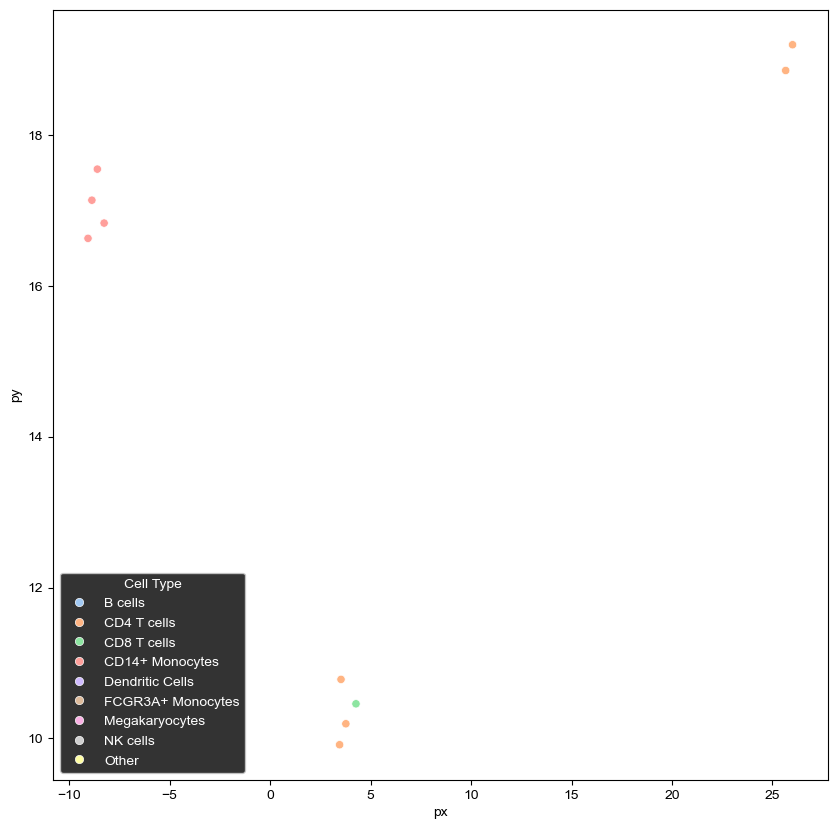

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(embeddings)

labels = ann_data.obs['cell_type'][:10]
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df, x='px', y='py', hue='Cell Type', sizes=(50,200), ax=ax, palette="pastel")
